In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
path0="/content/drive/MyDrive/Colab Notebooks/Investigación/"
path="/content/drive/MyDrive/Colab Notebooks/Investigación/narino/"

# Se instalan las bibliotecas

In [3]:
!pip install pykrige
!pip install geopandas
!pip install sklearnkernels

     |████████████████████████████████| 734 kB 14.3 MB/s 
     |████████████████████████████████| 1.0 MB 13.8 MB/s 
     |████████████████████████████████| 6.3 MB 50.1 MB/s 
     |████████████████████████████████| 15.4 MB 40 kB/s 
  Created wheel for sklearnkernels: filename=sklearnkernels-0.1.0-py3-none-any.whl size=6093 sha256=7c8badbafe7941e0d74786f21768f256544045913d74ebae03bc2bf21a75a5f9
  Stored in directory: /root/.cache/pip/wheels/ec/02/d6/9f3d962d56c89971631a6f39f23220b7094d7e409b39e1b9c5
Successfully built sklearnkernels


#Se importan las bibliotecas a utilizar

In [4]:
import pykrige #biblioteca de geoestadística
import pykrige.kriging_tools as kt #herramientas para exportar e importar archivos .asc con biblioteca PyKrige
from pykrige.ok import OrdinaryKriging #Kriging Ordinario con PyKrige
import pandas as pd #biblioteca de manipulación y análisis de datos
import numpy as np #biblioteca de funciones matemáticas
import matplotlib.pyplot as plt #biblioteca de generación de gráficos

import geopandas as gpd
import matplotlib.style
import matplotlib as mpl
from shapely.geometry import MultiPoint

In [5]:
mpl.style.use('seaborn-whitegrid')
shapefile = gpd.read_file(path+"narino_3857.shp")
print(shapefile['geometry'])

0    MULTIPOLYGON (((-8789647.510 178242.695, -8789...
Name: geometry, dtype: geometry


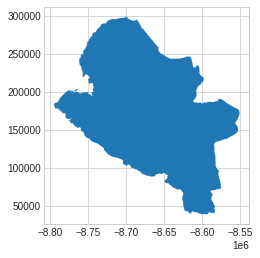

In [6]:
shapefile.plot()

In [7]:
from shapely.geometry import MultiPolygon

def points_from_polygons(polygons):
    points = []
    for mpoly in polygons:
        if isinstance(mpoly, MultiPolygon):
            polys = list(mpoly)
            print("YES")
        else:
            polys = [mpoly]
        for polygon in polys:
            for point in polygon.exterior.coords:
                points.append(point)
                
            for interior in polygon.interiors:
                for point in interior.coords:
                    points.append(point)
                
    return points

In [8]:
points = points_from_polygons(shapefile['geometry'])


YES


In [9]:
shp=shapefile['geometry']

In [10]:
import pandas as pd

from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV
from sklearnkernels.KSVM import  KSVC,KSVR

from sklearn.model_selection import train_test_split,KFold, cross_val_score,ShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
import numpy as np
from time import time
from multiprocessing.pool import Pool
from sklearn.metrics import mean_absolute_error,mean_squared_error,median_absolute_error
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from matplotlib.colors import LinearSegmentedColormap

In [11]:
dff=pd.read_csv(path0+'landsat_model.csv')        
dff

,latitude,longitude,band1,band2,band3,band4,band5,band6,band7,value
0,-8789850.0,184950.0,0.105113,0.082716,0.052756,0.315520,0.132641,296.178607,0.044586,203.4
1,-8784900.0,174600.0,0.104840,0.085732,0.053527,0.271463,0.090247,295.969710,0.027292,198.3
2,-8775000.0,164700.0,0.103468,0.079147,0.048932,0.248619,0.078593,296.842689,0.022098,203.1
3,-8775000.0,169650.0,0.108849,0.090665,0.055715,0.338889,0.128227,296.123927,0.039798,199.1
4,-8775000.0,174600.0,0.096526,0.071028,0.042247,0.194788,0.054468,294.407491,0.017712,196.3
...,...,...,...,...,...,...,...,...,...,...
429,-8559900.0,154800.0,0.078925,0.066239,0.047267,0.270656,0.109293,289.724062,0.044993,237.5
430,-8559900.0,169650.0,0.063235,0.047407,0.031352,0.156130,0.061570,286.148731,0.025417,236.1
431,-8559900.0,174600.0,0.078075,0.063393,0.042869,0.230624,0.089819,290.305318,0.035603,234.4
432,-8554950.0,154800.0,0.088854,0.074230,0.049634,0.296663,0.132079,293.226199,0.048379,221.4


In [12]:
def targeter(n_clases,min_v,max_v, val):
  intervals=np.linspace(min_v,max_v,n_clases)
  
  n=len(intervals)
  for i in range(n-1):    
    if val>=intervals[i] and val<intervals[i+1]:
      return i;
    if val == max_v:
      return n_clases-1

In [13]:
min_v=dff.value.min()
max_v=dff.value.max()
min_v,max_v

(188.5, 247.3)

In [14]:
from sklearn.preprocessing import KBinsDiscretizer

n_clases=5
dff['class_eq']=dff.value.apply(lambda x: targeter(n_clases,min_v,max_v,x))

dff['class2_km']=KBinsDiscretizer(n_bins=n_clases, encode='ordinal',strategy = "kmeans").fit_transform(dff[['value']])

dff['class2_qt']=KBinsDiscretizer(n_bins=n_clases, encode='ordinal',strategy = "quantile").fit_transform(dff[['value']])

dff['class2_uf']=KBinsDiscretizer(n_bins=n_clases, encode='ordinal',strategy = "uniform").fit_transform(dff[['value']])

# Se extraen la variable dependiente e independiente




In [15]:
#Variable independiente X
dff.iloc[:,0:9]

,latitude,longitude,band1,band2,band3,band4,band5,band6,band7
0,-8789850.0,184950.0,0.105113,0.082716,0.052756,0.315520,0.132641,296.178607,0.044586
1,-8784900.0,174600.0,0.104840,0.085732,0.053527,0.271463,0.090247,295.969710,0.027292
2,-8775000.0,164700.0,0.103468,0.079147,0.048932,0.248619,0.078593,296.842689,0.022098
3,-8775000.0,169650.0,0.108849,0.090665,0.055715,0.338889,0.128227,296.123927,0.039798
4,-8775000.0,174600.0,0.096526,0.071028,0.042247,0.194788,0.054468,294.407491,0.017712
...,...,...,...,...,...,...,...,...,...
429,-8559900.0,154800.0,0.078925,0.066239,0.047267,0.270656,0.109293,289.724062,0.044993
430,-8559900.0,169650.0,0.063235,0.047407,0.031352,0.156130,0.061570,286.148731,0.025417
431,-8559900.0,174600.0,0.078075,0.063393,0.042869,0.230624,0.089819,290.305318,0.035603
432,-8554950.0,154800.0,0.088854,0.074230,0.049634,0.296663,0.132079,293.226199,0.048379


In [16]:
# Variable dependiente y
dff.iloc[:,-4],dff.iloc[:,-3],dff.iloc[:,-2],dff.iloc[:,-1]

(0      1
 1      0
 2      0
 3      0
 4      0
       ..
 429    3
 430    3
 431    3
 432    2
 433    3
 Name: class_eq, Length: 434, dtype: int64, 0      1.0
 1      0.0
 2      1.0
 3      0.0
 4      0.0
       ... 
 429    4.0
 430    4.0
 431    4.0
 432    2.0
 433    4.0
 Name: class2_km, Length: 434, dtype: float64, 0      2.0
 1      2.0
 2      2.0
 3      2.0
 4      1.0
       ... 
 429    4.0
 430    4.0
 431    4.0
 432    3.0
 433    4.0
 Name: class2_qt, Length: 434, dtype: float64, 0      1.0
 1      0.0
 2      1.0
 3      0.0
 4      0.0
       ... 
 429    4.0
 430    4.0
 431    3.0
 432    2.0
 433    4.0
 Name: class2_uf, Length: 434, dtype: float64)

Text(0.5, 1.0, 'Uniforme')

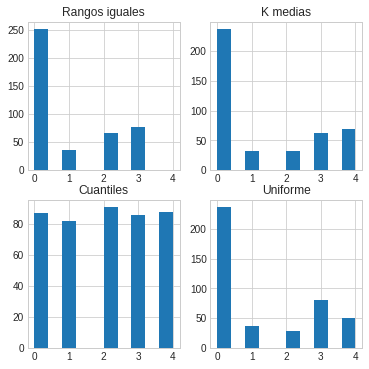

In [17]:
plt.figure(figsize=(6,6))
plt.subplot(2,2,1)
plt.title("Rangos iguales")
dff["class_eq"].hist()
plt.subplot(2,2,2)
dff["class2_km"].hist()
plt.title("K medias")
plt.subplot(2,2,3)
dff["class2_qt"].hist()
plt.title("Cuantiles")
plt.subplot(2,2,4)
dff["class2_uf"].hist()
plt.title("Uniforme")

#Se experimenta con los mejores dos modelos

#Equal discretizer

In [18]:
df=pd.read_csv(path0+"equal.csv",index_col=0)
df

,Scaler,kernel,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,best_param
0,SScaler,rquadratic,0.755253,0.118169,2.111319,0.031003,0.497785,0.006377,"{'svc__kernel': 'rquadratic', 'svc__gamma': 'a..."
1,SScaler,rbf,0.775889,0.139783,0.012039,0.002600,0.002172,0.001238,"{'svc__kernel': 'rbf', 'svc__gamma': 0.0006951..."
2,SScaler,tru,0.725528,0.061468,3.371575,0.043181,0.852029,0.034632,"{'svc__kernel': 'tru', 'svc__gamma': 545.55947..."
3,SScaler,can,0.706816,0.123740,3.961622,0.076741,0.980195,0.031704,"{'svc__kernel': 'can', 'svc__gamma': 0.0006951..."
4,SScaler,radial_basic,0.759824,0.132083,2.823305,0.044028,0.684439,0.022306,"{'svc__kernel': 'radial_basic', 'svc__gamma': ..."
5,SScaler,triangle,0.734616,0.094423,1.835867,0.034778,0.451213,0.010528,"{'svc__kernel': 'triangle', 'svc__gamma': 545...."
6,SScaler,hyperbolic,0.759824,0.124673,1.052734,0.076662,0.284842,0.015688,"{'svc__kernel': 'hyperbolic', 'svc__gamma': 0...."
7,MMScaler,rquadratic,0.759770,0.137278,2.095294,0.064085,0.519144,0.004372,"{'svc__kernel': 'rquadratic', 'svc__gamma': 'a..."
8,MMScaler,rbf,0.736835,0.109327,0.007945,0.001754,0.001664,0.000068,"{'svc__kernel': 'rbf', 'svc__gamma': 0.0006951..."
9,MMScaler,tru,0.736835,0.113361,3.434942,0.030515,0.855947,0.020897,"{'svc__kernel': 'tru', 'svc__gamma': 4.2813323..."


In [19]:
def kernels_name(data):
  if data=='rquadratic':
    return 'rq'
  if data=='radial_basic':
    return 'rb'
  if data=='triangle':
    return 'tri'
  if data=='hyperbolic':
    return 'hyp'
  return data

In [20]:
df['kernel2']=df.kernel.apply(lambda x:kernels_name(x))
df=df.sort_values(['mean_test_score'])
df

,Scaler,kernel,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,best_param,kernel2
20,NMScaler,hyperbolic,0.578348,0.004705,0.952743,0.013991,0.233853,0.005616,"{'svc__kernel': 'hyperbolic', 'svc__gamma': 0....",hyp
18,NMScaler,radial_basic,0.605747,0.064981,6.371808,1.192403,0.638141,0.059680,"{'svc__kernel': 'radial_basic', 'svc__gamma': ...",rb
14,NMScaler,rquadratic,0.628709,0.078815,2.099957,0.046344,0.489626,0.015507,"{'svc__kernel': 'rquadratic', 'svc__gamma': 'a...",rq
15,NMScaler,rbf,0.633333,0.075932,1.006690,0.586083,0.001659,0.000334,"{'svc__kernel': 'rbf', 'svc__gamma': 3792.6901...",rbf
16,NMScaler,tru,0.688452,0.105979,3.352869,0.024479,0.833767,0.014867,"{'svc__kernel': 'tru', 'svc__gamma': 0.0006951...",tru
19,NMScaler,triangle,0.700000,0.100888,1.669714,0.023141,0.417573,0.010550,"{'svc__kernel': 'triangle', 'svc__gamma': 0.00...",tri
3,SScaler,can,0.706816,0.123740,3.961622,0.076741,0.980195,0.031704,"{'svc__kernel': 'can', 'svc__gamma': 0.0006951...",can
10,MMScaler,can,0.723122,0.092317,3.994627,0.017040,0.958631,0.015766,"{'svc__kernel': 'can', 'svc__gamma': 0.0006951...",can
2,SScaler,tru,0.725528,0.061468,3.371575,0.043181,0.852029,0.034632,"{'svc__kernel': 'tru', 'svc__gamma': 545.55947...",tru
5,SScaler,triangle,0.734616,0.094423,1.835867,0.034778,0.451213,0.010528,"{'svc__kernel': 'triangle', 'svc__gamma': 545....",tri


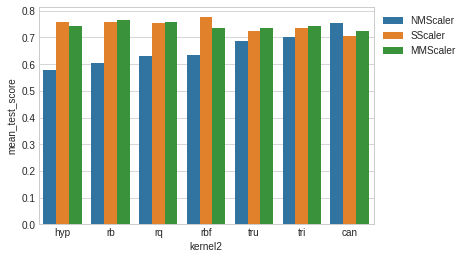

In [21]:
import seaborn as sns
ax=sns.barplot(x="kernel2", y="mean_test_score", data=df, hue='Scaler',orient='v')
ax.legend(bbox_to_anchor= (1,1))
plt.show()

In [22]:
df.iloc[df['mean_test_score'].argmax()]['best_param']

"{'svc__kernel': 'rbf', 'svc__gamma': 0.0006951927961775605, 'svc__C': 2154.4346900318847}"

In [23]:
from sklearn.pipeline import Pipeline

#Se particionan los datos EQ

In [24]:
X=dff.iloc[:,0:9].to_numpy()

In [25]:

y=dff.iloc[:,-4].to_numpy()
X.shape,y.shape

((434, 9), (434,))

In [26]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=2021 )

In [27]:
p_ss_KSVC = Pipeline([('scaler', StandardScaler()), ('KSVC', KSVC(kernel='rbf',gamma=0.0006951927961775605, C=2154.4346900318847))])

In [28]:
p_ss_KSVC.fit(X_train,y_train)
p_ss_KSVC.score(X_test,y_test)

0.8160919540229885

# Kmeans discretizer

In [29]:
dfk=pd.read_csv(path0+"kmean.csv",index_col=0)
dfk

,Scaler,kernel,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,best_param
0,SScaler,rquadratic,0.720797,0.101825,2.031577,0.024289,0.502851,0.006391,"{'svc__kernel': 'rquadratic', 'svc__gamma': 'a..."
1,SScaler,rbf,0.704544,0.124193,0.013191,0.003527,0.002367,0.001412,"{'svc__kernel': 'rbf', 'svc__gamma': 0.0006951..."
2,SScaler,tru,0.695242,0.144225,3.308899,0.030901,0.832924,0.015091,"{'svc__kernel': 'tru', 'svc__gamma': 4.2813323..."
3,SScaler,can,0.681262,0.172837,3.825552,0.009122,0.959343,0.019040,"{'svc__kernel': 'can', 'svc__gamma': 0.0006951..."
4,SScaler,radial_basic,0.725368,0.106846,2.756217,0.014348,0.685182,0.011674,"{'svc__kernel': 'radial_basic', 'svc__gamma': ..."
5,SScaler,triangle,0.702112,0.149621,1.778443,0.009947,0.415267,0.059198,"{'svc__kernel': 'triangle', 'svc__gamma': 11.2..."
6,SScaler,hyperbolic,0.683774,0.125750,0.940630,0.016436,0.236160,0.006468,"{'svc__kernel': 'hyperbolic', 'svc__gamma': 0...."
7,MMScaler,rquadratic,0.718658,0.063358,2.008712,0.010941,0.499364,0.006782,"{'svc__kernel': 'rquadratic', 'svc__gamma': 'a..."
8,MMScaler,rbf,0.704651,0.096725,0.009077,0.001693,0.001710,0.000084,"{'svc__kernel': 'rbf', 'svc__gamma': 0.0006951..."
9,MMScaler,tru,0.702112,0.148735,3.364278,0.022316,0.826893,0.013914,"{'svc__kernel': 'tru', 'svc__gamma': 3792.6901..."


In [30]:
dfk['kernel2']=dfk.kernel.apply(lambda x:kernels_name(x))
dfk=df.sort_values(['mean_test_score'])
dfk

,Scaler,kernel,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,best_param,kernel2
20,NMScaler,hyperbolic,0.578348,0.004705,0.952743,0.013991,0.233853,0.005616,"{'svc__kernel': 'hyperbolic', 'svc__gamma': 0....",hyp
18,NMScaler,radial_basic,0.605747,0.064981,6.371808,1.192403,0.638141,0.059680,"{'svc__kernel': 'radial_basic', 'svc__gamma': ...",rb
14,NMScaler,rquadratic,0.628709,0.078815,2.099957,0.046344,0.489626,0.015507,"{'svc__kernel': 'rquadratic', 'svc__gamma': 'a...",rq
15,NMScaler,rbf,0.633333,0.075932,1.006690,0.586083,0.001659,0.000334,"{'svc__kernel': 'rbf', 'svc__gamma': 3792.6901...",rbf
16,NMScaler,tru,0.688452,0.105979,3.352869,0.024479,0.833767,0.014867,"{'svc__kernel': 'tru', 'svc__gamma': 0.0006951...",tru
19,NMScaler,triangle,0.700000,0.100888,1.669714,0.023141,0.417573,0.010550,"{'svc__kernel': 'triangle', 'svc__gamma': 0.00...",tri
3,SScaler,can,0.706816,0.123740,3.961622,0.076741,0.980195,0.031704,"{'svc__kernel': 'can', 'svc__gamma': 0.0006951...",can
10,MMScaler,can,0.723122,0.092317,3.994627,0.017040,0.958631,0.015766,"{'svc__kernel': 'can', 'svc__gamma': 0.0006951...",can
2,SScaler,tru,0.725528,0.061468,3.371575,0.043181,0.852029,0.034632,"{'svc__kernel': 'tru', 'svc__gamma': 545.55947...",tru
5,SScaler,triangle,0.734616,0.094423,1.835867,0.034778,0.451213,0.010528,"{'svc__kernel': 'triangle', 'svc__gamma': 545....",tri


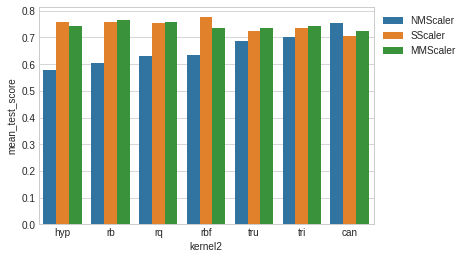

In [31]:
import seaborn as sns
ax=sns.barplot(x="kernel2", y="mean_test_score", data=dfk, hue='Scaler',orient='v')
ax.legend(bbox_to_anchor= (1,1))
plt.show()

In [32]:
dfk.iloc[dfk['mean_test_score'].argmax()]['best_param']

"{'svc__kernel': 'rbf', 'svc__gamma': 0.0006951927961775605, 'svc__C': 2154.4346900318847}"

In [33]:

y=dff.iloc[:,-3].to_numpy()
X.shape,y.shape

((434, 9), (434,))

In [34]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=2021 )

In [35]:
p_ss_KSVC = Pipeline([('scaler', StandardScaler()), ('KSVC', KSVC(kernel='rbf',gamma=0.0006951927961775605, C=2154.4346900318847))])

In [36]:
p_ss_KSVC.fit(X_train,y_train)
p_ss_KSVC.score(X_test,y_test)

0.7586206896551724

# Quatil Discretizer

In [37]:
dfq=pd.read_csv(path0+"quatil.csv",index_col=0)
dfq

,Scaler,kernel,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,best_param
0,SScaler,rquadratic,0.517990,0.111798,2.017405,0.012296,0.498676,0.004597,"{'svc__kernel': 'rquadratic', 'svc__gamma': 'a..."
1,SScaler,rbf,0.524886,0.112600,0.018193,0.004336,0.002329,0.000150,"{'svc__kernel': 'rbf', 'svc__gamma': 0.0006951..."
2,SScaler,tru,0.444346,0.107992,3.371600,0.062297,0.833191,0.009965,"{'svc__kernel': 'tru', 'svc__gamma': 545.55947..."
3,SScaler,can,0.423657,0.091089,3.894556,0.023892,0.965143,0.017444,"{'svc__kernel': 'can', 'svc__gamma': 0.0006951..."
4,SScaler,radial_basic,0.536327,0.126418,2.768862,0.013314,0.683677,0.011639,"{'svc__kernel': 'radial_basic', 'svc__gamma': ..."
5,SScaler,triangle,0.504250,0.084975,1.788022,0.009628,0.438039,0.007377,"{'svc__kernel': 'triangle', 'svc__gamma': 545...."
6,SScaler,hyperbolic,0.534055,0.127695,0.959405,0.016349,0.236668,0.009598,"{'svc__kernel': 'hyperbolic', 'svc__gamma': 0...."
7,MMScaler,rquadratic,0.529324,0.156235,1.998942,0.013808,0.496217,0.010883,"{'svc__kernel': 'rquadratic', 'svc__gamma': 'a..."
8,MMScaler,rbf,0.515718,0.102323,0.018081,0.003647,0.002175,0.000350,"{'svc__kernel': 'rbf', 'svc__gamma': 11.288378..."
9,MMScaler,tru,0.478856,0.108782,3.322172,0.034675,0.819016,0.006293,"{'svc__kernel': 'tru', 'svc__gamma': 4.2813323..."


In [38]:
dfq['kernel2']=dfq.kernel.apply(lambda x:kernels_name(x))
dfq=dfq.sort_values(['mean_test_score'])
dfq

,Scaler,kernel,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,best_param,kernel2
20,NMScaler,hyperbolic,0.310933,0.041600,0.951484,0.021915,0.242863,0.007046,"{'svc__kernel': 'hyperbolic', 'svc__gamma': 0....",hyp
18,NMScaler,radial_basic,0.324699,0.051745,2.760818,0.011166,0.697585,0.016785,"{'svc__kernel': 'radial_basic', 'svc__gamma': ...",rb
15,NMScaler,rbf,0.327132,0.050319,0.014678,0.001003,0.002773,0.000044,"{'svc__kernel': 'rbf', 'svc__gamma': 4.2813323...",rbf
14,NMScaler,rquadratic,0.345442,0.046637,2.019146,0.027128,0.458418,0.075972,"{'svc__kernel': 'rquadratic', 'svc__gamma': 'a...",rq
3,SScaler,can,0.423657,0.091089,3.894556,0.023892,0.965143,0.017444,"{'svc__kernel': 'can', 'svc__gamma': 0.0006951...",can
2,SScaler,tru,0.444346,0.107992,3.371600,0.062297,0.833191,0.009965,"{'svc__kernel': 'tru', 'svc__gamma': 545.55947...",tru
10,MMScaler,can,0.451350,0.079968,3.817305,0.027243,0.953491,0.013784,"{'svc__kernel': 'can', 'svc__gamma': 0.0006951...",can
9,MMScaler,tru,0.478856,0.108782,3.322172,0.034675,0.819016,0.006293,"{'svc__kernel': 'tru', 'svc__gamma': 4.2813323...",tru
17,NMScaler,can,0.490511,0.081183,3.834990,0.025073,0.956485,0.013801,"{'svc__kernel': 'can', 'svc__gamma': 4.2813323...",can
12,MMScaler,triangle,0.495001,0.086370,1.784050,0.024355,0.442983,0.006687,"{'svc__kernel': 'triangle', 'svc__gamma': 3792...",tri


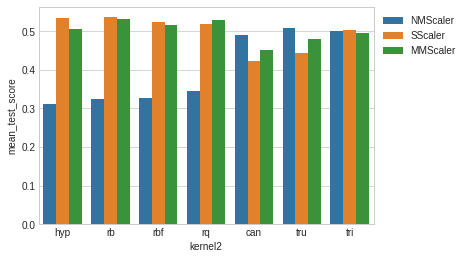

In [39]:
import seaborn as sns
ax=sns.barplot(x="kernel2", y="mean_test_score", data=dfq, hue='Scaler',orient='v')
ax.legend(bbox_to_anchor= (1,1))
plt.show()

In [40]:
dfq.iloc[dfq['mean_test_score'].argmax()]['best_param']

"{'svc__kernel': 'radial_basic', 'svc__gamma': 0.004832930238571752, 'svc__C': 3.5938136638046276}"

In [41]:

y=dff.iloc[:,-2].to_numpy()
X.shape,y.shape

((434, 9), (434,))

In [42]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=2021 )

In [43]:
p_ss_KSVC = Pipeline([('scaler', StandardScaler()), ('KSVC', KSVC(kernel='radial_basic',gamma=0.004832930238571752, C=3.5938136638046276))])

In [44]:
p_ss_KSVC.fit(X_train,y_train)
p_ss_KSVC.score(X_test,y_test)

0.6091954022988506

# Uniform Discretizer

In [45]:
dfu=pd.read_csv(path0+"uniform.csv",index_col=0)
dfu

,Scaler,kernel,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,best_param
0,SScaler,rquadratic,0.720904,0.066174,2.004225,0.016490,0.493617,0.006049,"{'svc__kernel': 'rquadratic', 'svc__gamma': 'a..."
1,SScaler,rbf,0.725314,0.111532,0.015108,0.004545,0.001711,0.000057,"{'svc__kernel': 'rbf', 'svc__gamma': 0.0006951..."
2,SScaler,tru,0.702593,0.038304,3.301597,0.020118,0.827554,0.013346,"{'svc__kernel': 'tru', 'svc__gamma': 545.55947..."
3,SScaler,can,0.672120,0.156057,3.825352,0.039517,0.967187,0.019027,"{'svc__kernel': 'can', 'svc__gamma': 0.0006951..."
4,SScaler,radial_basic,0.729912,0.110913,2.799793,0.026004,0.703371,0.026099,"{'svc__kernel': 'radial_basic', 'svc__gamma': ..."
5,SScaler,triangle,0.713847,0.097047,1.812603,0.023157,0.425377,0.065647,"{'svc__kernel': 'triangle', 'svc__gamma': 11.2..."
6,SScaler,hyperbolic,0.702245,0.114379,0.932732,0.014280,0.237839,0.005428,"{'svc__kernel': 'hyperbolic', 'svc__gamma': 0...."
7,MMScaler,rquadratic,0.727907,0.053083,2.021706,0.011897,0.506898,0.024072,"{'svc__kernel': 'rquadratic', 'svc__gamma': 'a..."
8,MMScaler,rbf,0.695563,0.066720,0.009692,0.002128,0.001775,0.000073,"{'svc__kernel': 'rbf', 'svc__gamma': 0.0006951..."
9,MMScaler,tru,0.697567,0.128137,3.359616,0.044478,0.842415,0.029247,"{'svc__kernel': 'tru', 'svc__gamma': 3792.6901..."


In [46]:
dfu['kernel2']=dfu.kernel.apply(lambda x:kernels_name(x))
dfu=dfu.sort_values(['mean_test_score'])
dfu

,Scaler,kernel,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,best_param,kernel2
20,NMScaler,hyperbolic,0.543785,0.004656,0.949250,0.029194,0.234791,0.008618,"{'svc__kernel': 'hyperbolic', 'svc__gamma': 0....",hyp
14,NMScaler,rquadratic,0.559690,0.059808,2.132962,0.099657,0.504647,0.027885,"{'svc__kernel': 'rquadratic', 'svc__gamma': 'a...",rq
15,NMScaler,rbf,0.566586,0.065510,1.788187,0.787126,0.001642,0.000259,"{'svc__kernel': 'rbf', 'svc__gamma': 3792.6901...",rbf
18,NMScaler,radial_basic,0.578081,0.066126,6.457122,0.786133,0.628371,0.057721,"{'svc__kernel': 'radial_basic', 'svc__gamma': ...",rb
16,NMScaler,tru,0.663165,0.097742,3.428201,0.077570,0.857983,0.037616,"{'svc__kernel': 'tru', 'svc__gamma': 0.0006951...",tru
19,NMScaler,triangle,0.667816,0.088915,1.658615,0.012154,0.403748,0.003206,"{'svc__kernel': 'triangle', 'svc__gamma': 0.00...",tri
3,SScaler,can,0.672120,0.156057,3.825352,0.039517,0.967187,0.019027,"{'svc__kernel': 'can', 'svc__gamma': 0.0006951...",can
8,MMScaler,rbf,0.695563,0.066720,0.009692,0.002128,0.001775,0.000073,"{'svc__kernel': 'rbf', 'svc__gamma': 0.0006951...",rbf
9,MMScaler,tru,0.697567,0.128137,3.359616,0.044478,0.842415,0.029247,"{'svc__kernel': 'tru', 'svc__gamma': 3792.6901...",tru
6,SScaler,hyperbolic,0.702245,0.114379,0.932732,0.014280,0.237839,0.005428,"{'svc__kernel': 'hyperbolic', 'svc__gamma': 0....",hyp


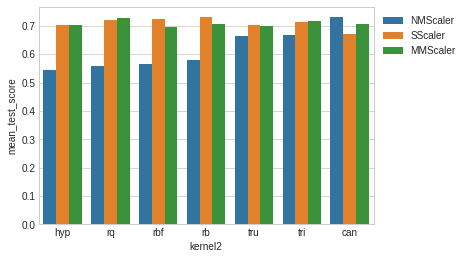

In [47]:
import seaborn as sns
ax=sns.barplot(x="kernel2", y="mean_test_score", data=dfu, hue='Scaler',orient='v')
ax.legend(bbox_to_anchor= (1,1))
plt.show()

In [48]:
dfu.iloc[dfu['mean_test_score'].argmax()]['best_param']

"{'svc__kernel': 'can', 'svc__gamma': 4.281332398719396, 'svc__C': 12.91549665014884}"

In [49]:

y=dff.iloc[:,-1].to_numpy()
X.shape,y.shape

((434, 9), (434,))

In [50]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=2021 )

In [51]:
p_ss_KSVC = Pipeline([('scaler', Normalizer()), ('KSVC', KSVC(kernel='can',gamma=4.281332398719396, C=12.91549665014884))])

In [52]:
p_ss_KSVC.fit(X_train,y_train)
p_ss_KSVC.score(X_test,y_test)

0.7816091954022989

# Visualizando Mapa de clasificación

In [59]:
z=p_ss_KSVC.predict(X)

In [65]:
x=X[:,0]
y=X[:,1]

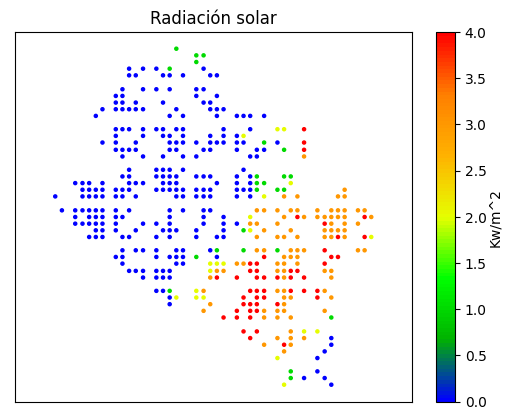

In [70]:
mpl.style.use('default')
colors = [(0, 0, 1), (0, 0.7, 0),(0, 1, 0),(0.9,1,0),(1,0.7,0),(1, 0.5, 0),(1, 0, 0) ]
cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)
marker_size = 5
plt.scatter(x, y, marker_size, z, cmap=cm) 
plt.axis('equal')
plt.title("Radiación solar")
cbar = plt.colorbar()
cbar.set_label("Kw/m^2", labelpad=+1)
plt.xticks([])
plt.yticks([])
plt.show()

In [78]:
dfnar=pd.read_csv(path+'gridNarinio.csv')
dfnar.head()
mpoints=np.array([dfnar["lat"].tolist(),dfnar["lon"]]).T
mpoints

array([[-8623484.29844098,    45000.        ],
       [-8622961.13585746,    45000.        ],
       [-8622437.97327394,    45000.        ],
       ...,
       [-8686786.97104677,   294750.        ],
       [-8686263.80846325,   294750.        ],
       [-8685740.64587973,   294750.        ]])

In [80]:
print("std2: ",round(z.var(), 2),"mean:",round(z.mean(), 2),
      "max:",round(z.max(), 2),"min:",round(z.min(), 2)) #Referencia para el variograma.

std2:  2.44 mean: 1.24 max: 4.0 min: 0.0


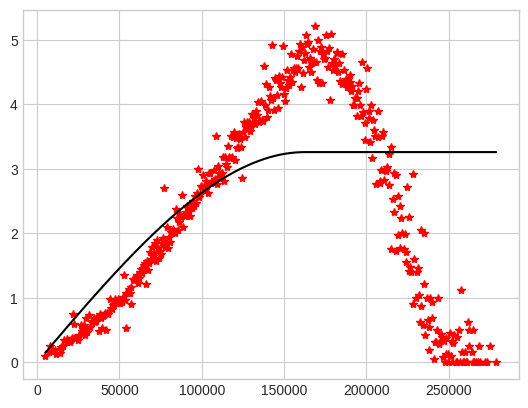

In [83]:
mpl.style.use('seaborn-whitegrid')
OK = OrdinaryKriging(x,y,z, variogram_model='spherical', nlags=450, 
                    enable_plotting=True, 
                    coordinates_type='euclidean')

In [84]:
x_min=x.min()
x_max=x.max()
y_min=y.min()
y_max=y.max()
grid_x = np.linspace(x_min, x_max, num=450, endpoint=False) #Se crean 46 celdas de 10 metros desde min() - max() del eje X.
grid_y = np.linspace(y_min, y_max, num=450, endpoint=False) #Se crean 41 celdas de 10 metros desde min() - max() del eje Y.

In [85]:
Xi =np.array([point[0] for point in mpoints])
Yi =np.array([point[1] for point in mpoints])

In [86]:
zf, ss = OK.execute('points', Xi, Yi) # z la radiacion y ss la varianza
zf

masked_array(data=[2.043517930689768, 2.0357667647530393,
                   2.0284580985599425, ..., 1.0880802938768392,
                   1.0876735607973982, 1.0871968942789565],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

In [88]:
def show_mapC(x,y,z):
    np.random.seed(19680801)       
    zi=z 
    Xi = x
    Yi = y
    
    colors = [(0, 0, 1), (0, 0.7, 0),(0, 1, 0),(0.9,1,0),(1,0.7,0),(1, 0.5, 0),(1, 0, 0) ]
    cmap_name = 'my_list'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)
    
    marker_size = 1
    
        
            
    plt.scatter(Xi, Yi, marker_size, zi, cmap=cm)
    
    plt.title("Radiación solar")
    cbar = plt.colorbar()
    cbar.set_label("W/m^2", labelpad=+1)
    plt.axis('equal')
    plt.xlabel("Este [X]")
    plt.ylabel("Norte [Y]")
    plt.show()

(434,) (434,)


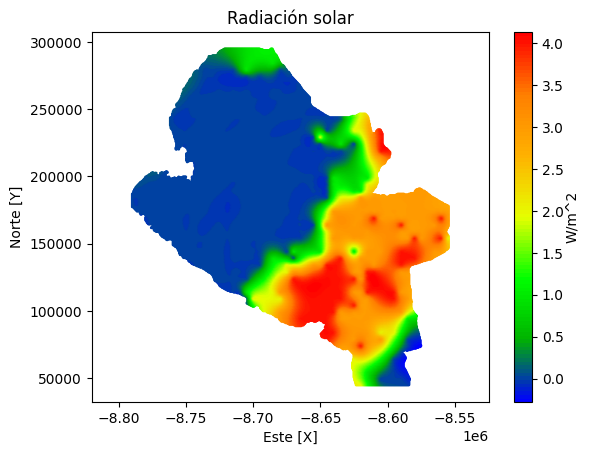

In [89]:
print(z.shape,x.shape)
mpl.style.use('default')
show_mapC(Xi,Yi,zf)